Model based analysis for the aging project

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special
from scipy.optimize import minimize 
import pingouin as pg

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [2]:
# Load Data
db = pd.read_csv('data/mon.csv')

# remove subjects with no lottery selections
n_lotery = db[['sub','choice']].groupby('sub').sum()
too_risk_averse = n_lotery[n_lotery['choice']<2].index.values
print("subs to remove for selecting only the ref", too_risk_averse)

db = db[db['sub'].isin(too_risk_averse) == False]


#db['subject'] = db['subn'].astype('category') 

# remove missing trials
db = db.dropna()
db['choice'] = db['choice'].astype('int')

#remove awarness check trials (value = 5)
#db = db[db['value']>5]

# get final number of subject and trials
n_subs = db['sub'].unique().shape[0]
print("Final sample includ {} subjects".format(n_subs))

subs to remove for selecting only the ref [11 40 65]
Final sample includ 71 subjects


In [3]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

age.columns.values[0] = "sub"
moca.columns.values[0] = "sub"
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))
print("number of participants with age and moca scores: ",age.shape[0])

number of participants with age and moca scores:  65


In [4]:
db = db.merge(age, left_on='sub', right_on='sub')
db['age'] = db.age.astype('int')
db = db[db.moca_score > 25]
db = db[db.catch < 6]

# add serial number for participants
db['subn'] = db['sub'].rank(method='dense').astype(int)-1

# sort dataframe based on subject, makes it easier to compare the output of the models.
db = db.sort_values('sub').reset_index(drop=True)

n_subs = db['subn'].unique().shape[0]
sub_idx = db.subn.tolist()
sub_idx = db.subn.tolist()

print("Final sample includ {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

Final sample includ 45 subjects and 3763 valid trials


re parametrize age

In [5]:
db['ageZ'] = (db['age'] - db['age'].mean())/db['age'].std(ddof=0)
db['age1'] = (db['age'])/100

Check model free as baseline

In [6]:
with pm.Model() as RiskAmb_free:
    

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)

    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    
    
      
    # Expected value of outcome
    svLotto = db['value'].values * (db['risk'].values - (db['ambiguity'].values/2))
    svRef = 5
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_free = pm.sample(4000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, gSig, gMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 35 seconds.


check Michael/Or model with alpha as a normal disterbution

In [7]:
with pm.Model() as RiskAmb_normal:
    # Hyper Priors
    aMu = pm.Normal('aMu', 0.7 ,1)
    aSig = pm.Exponential('aSig', 1)
    bMu = pm.Normal('bMu', 0,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)


    α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    
    
      
    # Expected value of outcome
    svLotto = (db['value'].values ** α[sub_idx]) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_normal = pm.sample(4000, return_inferencedata=True, target_accept=0.95)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, α, gSig, gMu, bSig, bMu, aSig, aMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 226 seconds.


I think Alpha should be a beta distribution

In [8]:
with pm.Model() as RiskAmb_Beta:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = (db['value'].values ** α[sub_idx]) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 243 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Compare models who fits the data best

In [9]:
az.compare({'model0': trace_free, 'model1': trace_normal, 'model2':trace_beta})

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/pyt

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2,0,-1243.949158,131.034880,0.000000,0.971232,37.877852,0.000000,True,log
model1,1,-1244.676575,129.574641,0.727417,0.000000,37.762362,1.185672,True,log
model0,2,-1792.670044,39.041874,548.720886,0.028768,31.698052,31.133687,True,log


Based on this result we take the winning model and add a layer of age on to it.
We will use the age as a Z distribution and the parameter as a normal one.

first model will see if age is part of the risk aversion

In [12]:
with pm.Model() as RiskAmbBeta_age_alphaHyper:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    a = pm.Beta('a', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', a * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    
    age = pm.Normal('age', 0, 1)
      
    # Expected value of outcome
    alpha = pm.Deterministic('alpha', α[sub_idx] + age * db['ageZ'].values)
    
    svLotto =  (db['value'].values ** alpha) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 5 ** alpha
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta_age_alphaHyper = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [age, γ, β, a, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 299 seconds.
The number of effective samples is smaller than 10% for some parameters.


another option is adding the alpha as a different parameter that affects the value

In [13]:
with pm.Model() as RiskAmbBeta_age_alpha_added:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    age = pm.Normal('age', 0, 1)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = (db['value'].values ** (α[sub_idx] + age * db['ageZ'].values)) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 5 ** (α[sub_idx]  + age * db['ageZ'].values)
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta_age_alpha_added = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, age, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 369 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [14]:
az.compare({'model2': trace_beta, 'model3': trace_beta_age_alphaHyper, 'model4':trace_beta_age_alpha_added})

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the margina

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model4,0,-1243.296641,130.262943,0.000000,1.000000e+00,37.830810,0.000000,True,log
model3,1,-1243.747504,130.660823,0.450863,1.665335e-16,37.896456,0.747565,True,log
model2,2,-1243.949158,131.034880,0.652517,0.000000e+00,37.877852,0.620445,True,log


So age affects risk aversion

Does age affect ambiguity as well?

First let's see if the same parameter can explain ambiguity related decision 

In [15]:
with pm.Model() as RiskAmbBeta_age_alpha_added_betaSame:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    age = pm.Normal('age', 0, 1)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = (db['value'].values ** (α[sub_idx] + age * db['ageZ'].values)) * (db['risk'].values - ((β[sub_idx] + age * db['ageZ'].values) * (db['ambiguity'].values/2)))
    svRef = 5 ** (α[sub_idx]  + age * db['ageZ'].values)
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta_age_alpha_added_betaSame = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, age, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 342 seconds.
The number of effective samples is smaller than 10% for some parameters.


Or does ambiguity have a different effect?

In [16]:
with pm.Model() as RiskAmbBeta_age_alpha_added_betaDiff:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    agea = pm.Normal('agea', 0, 1)
    ageb = pm.Normal('ageb', 0, 1)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = (db['value'].values ** (α[sub_idx] + agea * db['ageZ'].values)) * (db['risk'].values - ((β[sub_idx] + ageb * db['ageZ'].values) * (db['ambiguity'].values/2)))
    svRef = 5 ** (α[sub_idx]  + agea * db['ageZ'].values)
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta_age_alpha_added_betaDiff = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, ageb, agea, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 426 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [17]:
az.compare({'model2': trace_beta, 'model4':trace_beta_age_alpha_added, 'model5': trace_beta_age_alpha_added_betaSame, 'model6': trace_beta_age_alpha_added_betaDiff})

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape par

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model4,0,-1243.296641,130.262943,0.000000,0.604433,37.830810,0.000000,True,log
model5,1,-1243.327477,130.316864,0.030836,0.395567,37.756484,0.573765,True,log
model2,2,-1243.949158,131.034880,0.652517,0.000000,37.877852,0.620445,True,log
model6,3,-1244.887581,132.186470,1.590940,0.000000,38.198001,1.059660,True,log


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

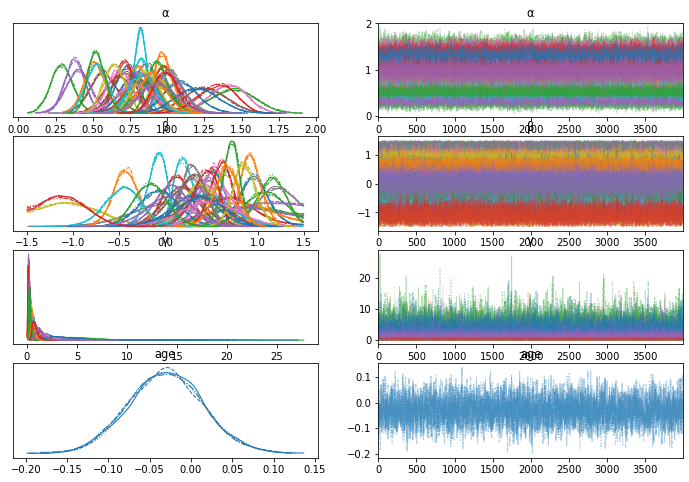

In [18]:
az.plot_trace(trace_beta_age_alpha_added, var_names=['α','β','γ','age'])

In [24]:
az.summary(trace_beta_age_alpha_added, var_names='age', hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age,-0.031,0.045,-0.106,0.038,0.001,0.001,3499.0,5722.0,1.0
